# Install AI2-THOR

ProcTHOR houses are loaded into `ai2thor` and distributed with the `prior` package. We'll also install a helper package, called `ai2thor_colab`, which allows us to run AI2-THOR in Google Colab.

Let's install each of these packages below:

In [1]:
# Here, we'll install and use a pre-release of AI2-THOR.
!pip install --upgrade ai2thor --quiet
!pip install ai2thor-colab prior --upgrade &> /dev/null

# Download ProcTHOR-10k

Now, let's use the `prior` package to easily download the `procthor-10k` dataset:

In [2]:
import prior

dataset = prior.load_dataset("procthor-10k")
dataset

[AI2-THOR WARNING] There has been an update to ProcTHOR-10K that must be used with AI2-THOR version 5.0+. To use the new version of ProcTHOR-10K, please update AI2-THOR to version 5.0+ by running:
    pip install --upgrade ai2thor
Alternatively, to downgrade to the old version of ProcTHOR-10K, run:
   prior.load_dataset("procthor-10k", revision="ab3cacd0fc17754d4c080a3fd50b18395fae8647")


Loading test: 100%|██████████| 1000/1000 [00:01<00:00, 834.09it/s]


DatasetDict(
    train=Dataset(
    dataset=procthor-dataset,
    size=10000,
    split=train
),
    val=Dataset(
    dataset=procthor-dataset,
    size=1000,
    split=val
),
    test=Dataset(
    dataset=procthor-dataset,
    size=1000,
    split=test
)
)

ProcTHOR-10k comes with 3 splits, including:
- 10k `"train"` houses
- 1k `"val"` houses
- 1k `"test"` houses

these can be obtained by indexing into the dataset:

In [3]:
dataset["train"]

Dataset(
    dataset=procthor-dataset,
    size=10000,
    split=train
)

Here is an example of how to load a single house's JSON file:

In [4]:
house = dataset["train"][0]
type(house), house.keys(), house

(dict,
 dict_keys(['doors', 'metadata', 'objects', 'proceduralParameters', 'rooms', 'walls', 'windows']),
 {'doors': [{'assetId': 'Doorway_6',
    'id': 'door|1|2',
    'openable': False,
    'openness': 0,
    'room0': 'room|2',
    'room1': 'room|2',
    'wall0': 'wall|2|5.99|3.99|5.99|5.99',
    'wall1': 'wall|exterior|5.99|3.99|5.99|5.99',
    'holePolygon': [{'x': 0.4987163812589276, 'y': 0, 'z': 0},
     {'x': 1.5362947256040203, 'y': 2.1068506240844727, 'z': 0}],
    'assetPosition': {'x': 1.016530884310268,
     'y': 1.0534253120422363,
     'z': 0}}],
  'metadata': {'agent': {'horizon': 30,
    'position': {'x': 3.5, 'y': 0.95, 'z': 2.0},
    'rotation': {'x': 0, 'y': 90, 'z': 0},
    'standing': True},
   'roomSpecId': 'kitchen',
   'schema': '1.0.0',
   'warnings': {},
   'agentPoses': {'arm': {'horizon': 30,
     'position': {'x': 3.5, 'y': 0.95, 'z': 2.0},
     'rotation': {'x': 0, 'y': 90, 'z': 0},
     'standing': True},
    'default': {'horizon': 30,
     'position': {'

# Load a house into AI2-THOR

First, let's import in a Controller from AI2-THOR:

In [5]:
from ai2thor.controller import Controller

To run AI2-THOR in Google Colab, we need to start an xserver, which allows us to load and observe images from the AI2-THOR Unity application, without having an external monitor or a GPU. Here, we'll use `ai2thor_colab`'s `start_xserver` function:

In [6]:
import ai2thor_colab
ai2thor_colab.start_xserver()

Let's now choose a ProcTHOR house we want to load into AI2-THOR:

In [7]:
house = dataset["train"][3]

And create a Controller that is initialized to that scene:

In [8]:
controller = Controller(scene=house)

  warnings.warn(



  warnings.warn(



# Egocentric Images

We now have an agent placed in the scene ready to execute actions! Let's check out what it's looking at:

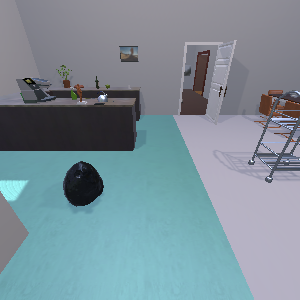

In [9]:
from PIL import Image

Image.fromarray(controller.last_event.frame)

# Navigation Actions

And take a few steps around:

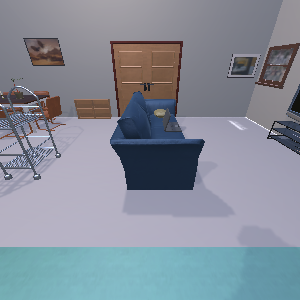

In [10]:
event = controller.step(action="RotateRight")
Image.fromarray(event.frame)

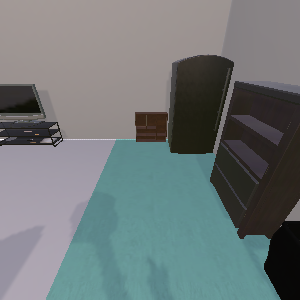

In [11]:
event = controller.step(action="RotateRight")
Image.fromarray(event.frame)

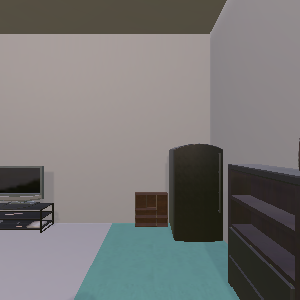

In [12]:
event = controller.step(action="LookUp")
Image.fromarray(event.frame)

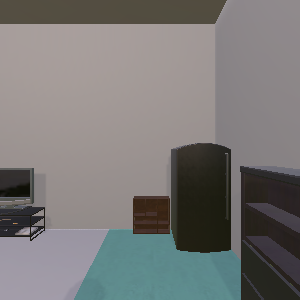

In [13]:
event = controller.step(action="MoveAhead")
Image.fromarray(event.frame)

# Top-Down Frame

We can also get a top-down image of the frame:

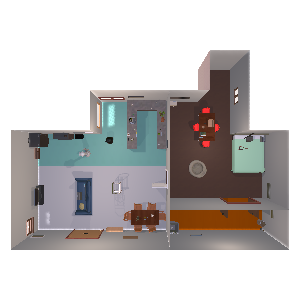

In [15]:
import copy

def get_top_down_frame():
    # Setup the top-down camera
    event = controller.step(action="GetMapViewCameraProperties", raise_for_failure=True)
    pose = copy.deepcopy(event.metadata["actionReturn"])

    bounds = event.metadata["sceneBounds"]["size"]
    max_bound = max(bounds["x"], bounds["z"])

    pose["fieldOfView"] = 50
    pose["position"]["y"] += 1.1 * max_bound
    pose["orthographic"] = False
    pose["farClippingPlane"] = 50
    del pose["orthographicSize"]

    # add the camera to the scene
    event = controller.step(
        action="AddThirdPartyCamera",
        **pose,
        skyboxColor="white",
        raise_for_failure=True,
    )
    top_down_frame = event.third_party_camera_frames[-1]
    return Image.fromarray(top_down_frame)


get_top_down_frame()

# Randomize the Agent's Position

To randomize the agent's position, we can get the set of grid positions that the agent can reach from 90 degree rotations and 0.25m separated movements. Here, we'll call `GetReachablePositions`:

In [16]:
event = controller.step(action="GetReachablePositions")
event.metadata["actionReturn"]

[{'x': 3.25, 'y': 0.9009997844696045, 'z': 5.0},
 {'x': 3.5, 'y': 0.9009997844696045, 'z': 5.0},
 {'x': 3.25, 'y': 0.9009997844696045, 'z': 5.25},
 {'x': 3.0, 'y': 0.9009997844696045, 'z': 5.0},
 {'x': 3.25, 'y': 0.9009997844696045, 'z': 4.75},
 {'x': 3.75, 'y': 0.9009997844696045, 'z': 5.0},
 {'x': 3.5, 'y': 0.9009997844696045, 'z': 5.25},
 {'x': 3.5, 'y': 0.9009997844696045, 'z': 4.75},
 {'x': 3.25, 'y': 0.9009997844696045, 'z': 5.5},
 {'x': 3.0, 'y': 0.9009997844696045, 'z': 5.25},
 {'x': 2.75, 'y': 0.9009997844696045, 'z': 5.0},
 {'x': 3.0, 'y': 0.9009997844696045, 'z': 4.75},
 {'x': 3.25, 'y': 0.9009997844696045, 'z': 4.5},
 {'x': 4.0, 'y': 0.9009997844696045, 'z': 5.0},
 {'x': 3.75, 'y': 0.9009997844696045, 'z': 5.25},
 {'x': 3.75, 'y': 0.9009997844696045, 'z': 4.75},
 {'x': 3.5, 'y': 0.9009997844696045, 'z': 5.5},
 {'x': 3.5, 'y': 0.9009997844696045, 'z': 4.5},
 {'x': 3.25, 'y': 0.9009997844696045, 'z': 5.75},
 {'x': 3.0, 'y': 0.9009997844696045, 'z': 5.5},
 {'x': 2.75, 'y': 0.9

And to visualize these positions, let's plot them on a scatter plot:

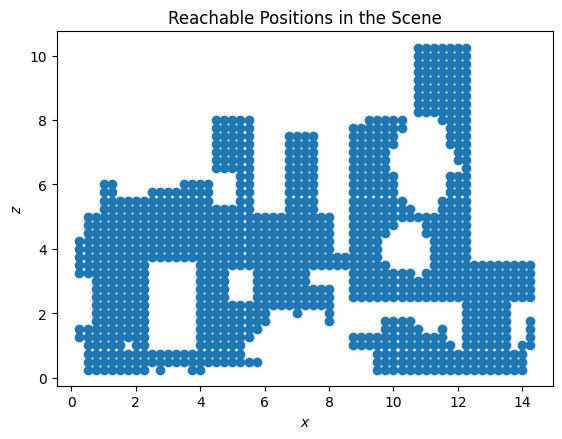

In [17]:
import matplotlib.pyplot as plt
reachable_positions = event.metadata["actionReturn"]
xs = [rp["x"] for rp in reachable_positions]
zs = [rp["z"] for rp in reachable_positions]

fig, ax = plt.subplots(1, 1)
ax.scatter(xs, zs)
ax.set_xlabel("$x$")
ax.set_ylabel("$z$")
ax.set_title("Reachable Positions in the Scene")
ax.set_aspect("equal")

Now, let's randomize the agent's position and rotation:

Teleporting the agent to {'x': 3.5, 'y': 0.9009997844696045, 'z': 4.75}  with rotation 224


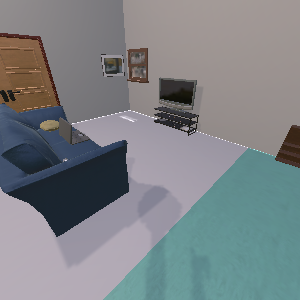

In [18]:
import random

position = random.choice(reachable_positions)
rotation = random.choice(range(360))
print("Teleporting the agent to", position, " with rotation", rotation)

event = controller.step(action="Teleport", position=position, rotation=rotation)

Image.fromarray(event.frame)

# Randomize Object Materials

To randomize the materials of objects, we can use the `RandomizeMaterials` function:

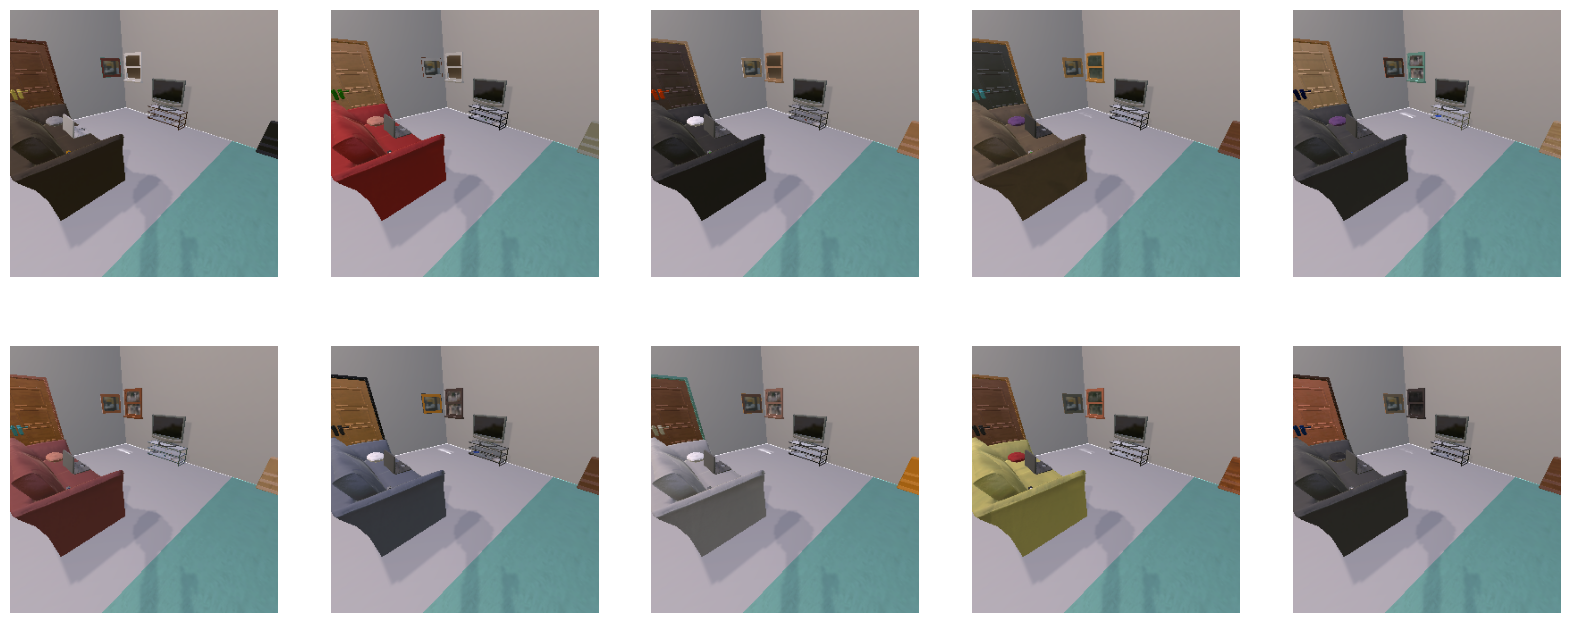

In [19]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

for ax in axs.flat:
    event = controller.step(action="RandomizeMaterials")
    ax.imshow(event.frame)
    ax.axis("off")

# Changing houses

To switch the agent to a different house, we can use AI2-THOR's `reset` method:

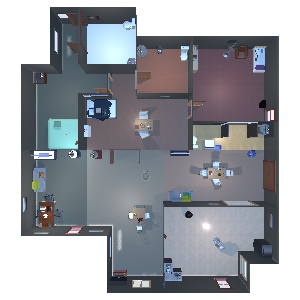

In [ ]:
new_house = dataset["train"][1]
controller.reset(scene=new_house)

get_top_down_frame()

# More Details

This notebook provided a very minimal demo to get started with ProcTHOR. More about ProcTHOR will be open-sourced and documented soon.

For more details about how to use AI2-THOR, please checkout the API references at [ai2thor.allenai.org](https://ai2thor.allenai.org).